## Abstract

In this project, I aim to replicate and extend the findings of Obermeyer et al. (2019) by exploring how healthcare cost predictions relate to patients’ chronic illness burden and race. Using a randomized dataset, we first visualize the relationship between risk score percentiles, chronic conditions, and medical expenditures, revealing that White patients tend to generate higher costs than Black patients despite similar illness burdens. We then built a Ridge regression model with polynomial features to quantify the disparity in costs between Black and White patients. Our final model estimates that, holding illness burden constant, Black patients incur roughly 81% of the costs incurred by White patients, suggesting that the cost-based risk score underestimates the true care needs of Black patients.


## Exploring the Data
Below we will accesss the data clean it and explore the different variables and features.

In [7]:
import pandas as pd
url = "https://gitlab.com/labsysmed/dissecting-bias/-/raw/master/data/data_new.csv?inline=false"
df = pd.read_csv(url)
df.head()

,risk_score_t,program_enrolled_t,cost_t,cost_avoidable_t,bps_mean_t,ghba1c_mean_t,hct_mean_t,cre_mean_t,ldl_mean_t,race,...,trig_min-high_tm1,trig_min-normal_tm1,trig_mean-low_tm1,trig_mean-high_tm1,trig_mean-normal_tm1,trig_max-low_tm1,trig_max-high_tm1,trig_max-normal_tm1,gagne_sum_tm1,gagne_sum_t
0,1.987430,0,1200.0,0.0,NaN,5.4,NaN,1.110000,194.0,white,...,0,0,0,0,0,0,0,0,0,0
1,7.677934,0,2600.0,0.0,119.0,5.5,40.4,0.860000,93.0,white,...,0,1,0,0,1,0,0,1,4,3
2,0.407678,0,500.0,0.0,NaN,NaN,NaN,NaN,NaN,white,...,0,0,0,0,0,0,0,0,0,0
3,0.798369,0,1300.0,0.0,117.0,NaN,NaN,NaN,NaN,white,...,0,0,0,0,0,0,0,0,0,0
4,17.513165,0,1100.0,0.0,116.0,NaN,34.1,1.303333,53.0,white,...,0,0,0,0,0,0,0,0,1,1


Our code below checks the ratio of white patients to black patiens before dropping NA values and after dorpping them. There is clearly a big difference in the ratio of black to white people in our dataset, which is something to keep in mind.

In [8]:
race_counts_bf_clean = df['race'].value_counts()
df.dropna(inplace=True)
race_counts = df['race'].value_counts()
print("Count of patients by race before cleaning data",race_counts_bf_clean)
print("Count of patients by race after cleaning data", race_counts)

Count of patients by race before cleaning data race
white    43202
black     5582
Name: count, dtype: int64
Count of patients by race after cleaning data race
white    5911
black    1000
Name: count, dtype: int64


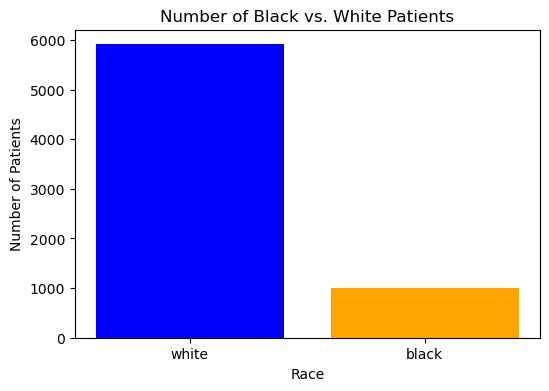

In [9]:
import  matplotlib.pyplot as plt
import seaborn as sns
# Graph 1: Bar chart of race counts
plt.figure(figsize=(6, 4))
plt.bar(race_counts.index, race_counts.values, color=['blue', 'orange'])
plt.xlabel('Race')
plt.ylabel('Number of Patients')
plt.title('Number of Black vs. White Patients')
plt.show()


Below is a scatter plot to visualize the Risk Score vs the Cost by race and see a lot of clustering. So we will need to further clean our data to get better visualizations.

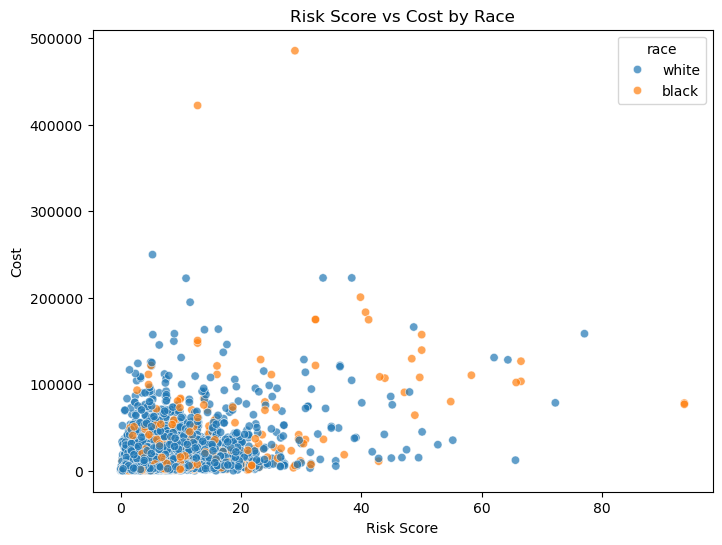

In [10]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="risk_score_t", y="cost_t", hue="race", alpha=0.7)

# Labels and title
plt.xlabel("Risk Score")
plt.ylabel("Cost")
plt.title("Risk Score vs Cost by Race")
plt.show()

## Plotting risk score percentiles against mean number of active chronic conditions within that percentile

Our code below shows us a plot explaining how the algorithm’s risk score percentile (y-axis) increases as the average number of chronic illnesses (x-axis) goes up, with points colored by race. Generally, patients with more chronic illnesses receive a higher risk score.

However, if a Black patient and a White patient both have the same chronic illnesses, the Black patient often ends up with a lower risk score than the White patient. Because the care management program looks for patients with high risk scores, the Black patient with the same health conditions is less likely to be flagged for extra care—this is the key concern the Obermeyer et al. (2019) highlights.

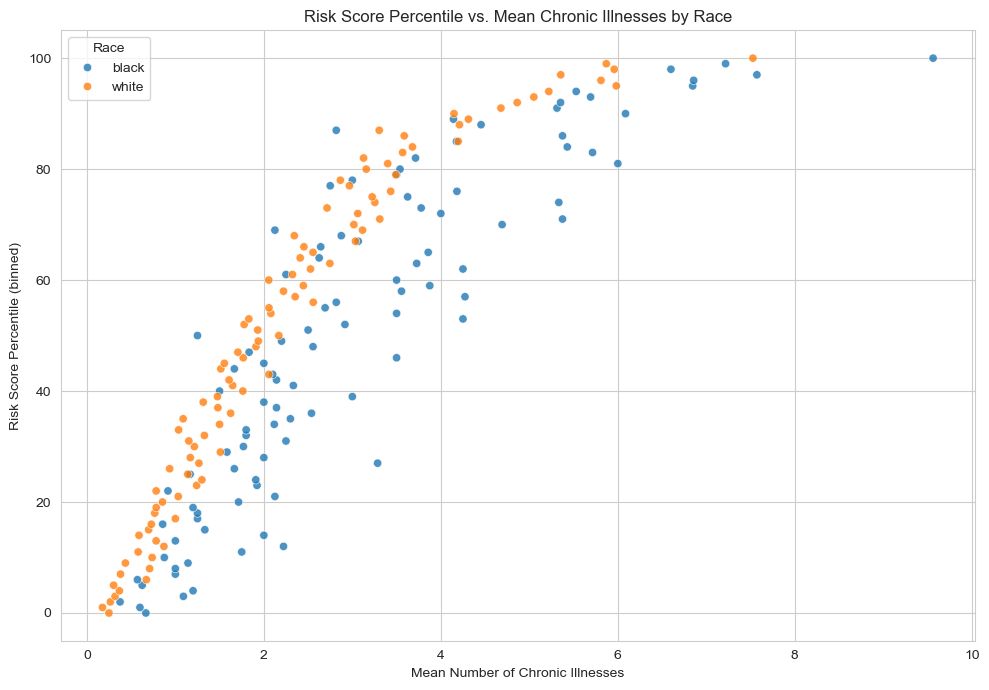

In [11]:
import numpy as np
import seaborn as sns

df['risk_percentile'] = df['risk_score_t'].rank(pct=True) * 100
df['risk_p_bin'] = df['risk_percentile'].round() # Rounding it to the nearest integer

# Group by race & risk percentile; compute mean chronic illnesses
grouped = (
    df.groupby(['race', 'risk_p_bin'], as_index=False)
      .agg(mean_chronic=('gagne_sum_t', 'mean'))
)


sns.set_style("whitegrid")
plt.figure(figsize=(10, 7))

sns.scatterplot(
    data=grouped,
    x='mean_chronic',     
    y='risk_p_bin',       
    hue='race',
    alpha=0.8
)


plt.xlabel("Mean Number of Chronic Illnesses")
plt.ylabel("Risk Score Percentile (binned)")
plt.title("Risk Score Percentile vs. Mean Chronic Illnesses by Race")
plt.legend(title="Race")

plt.tight_layout()
plt.show()

## Visualizing the Relationship Between Risk Score, Chronic Illness, and Healthcare Costs

Something we notice in both our graphs is that White patients (displayed in orange) tend to generate higher medical costs than Black patients (displayed as blue dots) at similar risk score percentiles or similar numbers of chronic illnesses. This finding aligns with the paper’s discussion of a “wedge” between needing care and receiving (or using) care: even when Black and White patients have the same burden of chronic illnesses, White patients often end up with higher total expenditures.

It’s also notable that the vast majority of patients have relatively few chronic conditions . Only a small subset of patients have 10 or more illnesses, yet these high-illness groups appear to have an influence on total costs. This illustrates how a minority of patients with many chronic conditions can account for a disproportionately large share of healthcare spending.

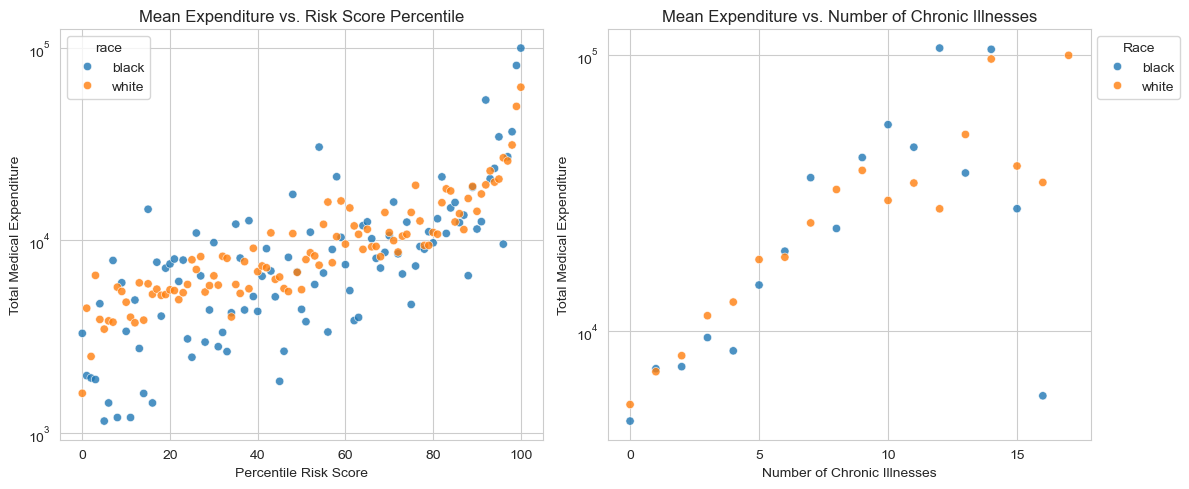

In [12]:
# Group for percentile risk score
grouped_risk = (
    df.groupby(['race', 'risk_p_bin'], as_index=False)
      .agg(mean_cost=('cost_t', 'mean'))
)
# Group for numbe rof chronic illness
grouped_chronic = (
    df.groupby(['race', 'gagne_sum_t'], as_index=False)
      .agg(mean_cost=('cost_t', 'mean'))
)

# fitting the  subplots, side by side
fig, axes = plt.subplots(ncols=2, figsize=(12, 5))

# plotting the percentile risk score
sns.scatterplot(
    data=grouped_risk,
    x='risk_p_bin',
    y='mean_cost',
    hue='race',
    alpha=0.8,
    ax=axes[0]
)
axes[0].set_title("Mean Expenditure vs. Risk Score Percentile")
axes[0].set_xlabel("Percentile Risk Score")
axes[0].set_ylabel("Total Medical Expenditure")
axes[0].set_xticks([0, 20, 40, 60, 80, 100])  # Custom x-ticks

# using a log scale for the y-axis
axes[0].set_yscale('log')

# plotting the number of chronic illnesses
sns.scatterplot(
    data=grouped_chronic,
    x='gagne_sum_t',
    y='mean_cost',
    hue='race',
    alpha=0.8,
    ax=axes[1]
)
axes[1].set_title("Mean Expenditure vs. Number of Chronic Illnesses")
axes[1].set_xlabel("Number of Chronic Illnesses")
axes[1].set_ylabel("Total Medical Expenditure")


# Custom x-ticks
axes[1].set_xticks([0, 5, 10, 15])

# using a log scale for the y-axis
axes[1].set_yscale('log')

axes[1].legend(title="Race", loc="upper left", bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

In our code below we calculate percentage of patients with 5 or fewer chronic conditions and see that about 90% of patients have five or fewer chronic conditions, so by focusing on this group, you’re still covering the vast majority of the dataset. That makes it a reasonable choice: it simplifies the analysis while still capturing most patients’ experiences.

In [13]:
# 2. Remove patients with $0 medical costs because log(0) is undefined
df = df[df['cost_t'] > 0]

# Determine the percentage of patients with 5 or fewer chronic conditions
total_patients = df.shape[0]
patients_5_or_fewer = df[df['gagne_sum_t'] <= 5].shape[0]
percentage_5_or_fewer = (patients_5_or_fewer / total_patients) * 100
print("Percentage of patients with 5 or fewer chronic conditions: ", (percentage_5_or_fewer))


Percentage of patients with 5 or fewer chronic conditions:  89.79413053000438



## Modeling our Data

In our code belwo we perform three main steps to prepare our data for modeling:

* Log-Transforming Costs: We create a new column log_cost by taking the natural log of cost_t. This transformation helps manage the large range of healthcare expenses, making it easier for a regression model to handle.

* One-Hot Encoding Race: We introduce a race_dummy variable where Black patients are assigned a value of 1 and White patients a value of 0. Turning the categorical race variable into a numeric format allows the model to incorporate race as a predictor.

* Defining Predictors and Target: Our predictor variables (X) are the dummy-coded race variable (race_dummy) and the total number of chronic conditions (gagne_sum_t). Our target variable (y) is the log-transformed cost (log_cost). 

In [14]:
#log-transform of the cost
df['log_cost'] = np.log(df['cost_t'])

# one-hot encoding race
df['race_dummy'] = (df['race'] == 'black').astype(int)

#Separate the data into predictor variables (X) and the target variable (y)
#   For predictors, we use the onehot encoded race variavle and the number of chronic conditions.
X = df[['race_dummy', 'gagne_sum_t']]
y = df['log_cost']

print(X['race_dummy'].value_counts())

print("Predictor variables x")

print(X.head()) 

print("Target variable y")

print(y.head())

race_dummy
0    5851
1     998
Name: count, dtype: int64
Predictor variables x
    race_dummy  gagne_sum_t
1            0            3
8            1            1
15           0            1
19           0            0
21           0            2
Target variable y
1     7.863267
8     6.907755
15    7.313220
19    8.594154
21    8.318742
Name: log_cost, dtype: float64


## Modeling our Cost Disparity 

In our code below we built our model to assess the cost disparity. So we do this by building a polynomial regression model to explore the relationship between the number of chronic illnesses, race, and healthcare costs. In order to this we had to do the following steps

* Transforming the Data: We applied a log transformation to the cost variable to handle its wide range of values. In addition to that We one-hot encoded race, where Black patients were assigned 1 and White patients were assigned 0.

* Generating Polynomial Features: Since the relationship between chronic conditions and cost  was not linear, we created polynomial features up to degree 11 to capture nonlinearity.

* Hyperparameter Tuning:  We tested different polynomial degrees (1 to 11) and regularization strengths (Ridge regression with $\alpha = 10^k$ for $k = -4, -3, \dots, 3, 4$). Using cross-validation, we identified the combination that minimized the mean squared error (MSE).

* Fitting the Final Model: Once we found the best degree (9) and regularization strength ($\alpha = 10$), we trained our final Ridge regression model. We extracted the coefficient for race ($w_b$), which indicates the impact of being Black on predicted log-cost. We computed $e^{w_b}$, which tells us the relative cost of Black patients compared to White patients with similar illness burdens.

In [15]:
import warnings
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import Ridge

def add_polynomial_features(X, degree):
    """
    Adds polynomial terms for 'gagne_sum_t' up to the specified degree.
    """
    X_ = X.copy()

    for j in range(1, degree + 1):
        X_[f"poly_{j}"] = X_["gagne_sum_t"] ** j
    return X_

# create a hyperparameter grid for the polynomial degree
degrees = range(1, 12)               # 1 through 11
alphas = [10**k for k in range(-4, 5)]  # 10^-4 through 10^4

# Initialize the best score to positive infinity and the best parameters to None
# cross-validation will update these variables
best_score = np.inf
best_params = (None, None)  # (degree, alpha)


with warnings.catch_warnings():
    warnings.filterwarnings("ignore")

    for deg in degrees:
        # Create polynomial features up to 'deg'
        X_poly = add_polynomial_features(X[['gagne_sum_t']], deg)
        # we include the race dummy column as well
        X_poly['race_dummy'] = X['race_dummy']
        
        for alpha in alphas:
            # creating a Ridge model with the given alpha
            model = Ridge(alpha=alpha)
            
            # 5-fold cross-validation using negative MSE (sklearn uses negative MSE by default)
            scores = cross_val_score(model, X_poly, y, cv=5, scoring='neg_mean_squared_error')
            mean_mse = -np.mean(scores)  # convert negative MSE to MSE

            # Update if we find a better (lower) MSE
            if mean_mse < best_score:
                best_score = mean_mse
                best_params = (deg, alpha)

print("Best degree and alpha:", best_params)
print("Cross Validated MSE:", best_score)

# final model
best_degree = best_params[0]
best_alpha = best_params[1]

# Build the final model using the polynomial degree and alpha that gave the best MSE
X_final = add_polynomial_features(X[['gagne_sum_t']], best_degree)
X_final['race_dummy'] = X['race_dummy']

# Fit the final model
final_model = Ridge(alpha=best_alpha)
final_model.fit(X_final, y)

coef_names = list(X_final.columns)
coefs = final_model.coef_

race_index = coef_names.index("race_dummy")
race_coef = coefs[race_index]

# Compute e^(wb)
race_factor = np.exp(race_coef)

print("Race factor (e^(wb)):", race_factor)


Best degree and alpha: (9, 10)
Cross Validated MSE: 1.206333568523416
Race factor (e^(wb)): 0.8095004382057049


/Users/prashanthbabu/anaconda3/envs/ml-0451/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=2.53171e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


## Interpretting our results:

The best polynomial degree was 9, suggesting a complex, nonlinear relationship between chronic conditions and cost. The regularization strength $\alpha = 10$ helped control overfitting while preserving useful patterns.

The race coefficient ($w_b$) resulted in a computed value of $e^{w_b} \approx 0.81$, meaning Black patients incur only $\sim 81\%$ of the healthcare costs of equally sick White patients. This result aligns with the argument in Obermeyer et al. (2019)—that healthcare cost data underestimates Black patients’ need for care. Since cost data is used to determine who gets extra healthcare resources, this disparity can lead to biased decision-making, where Black patients may be less likely to be enrolled in high-risk management programs despite having the same number of chronic conditions as White patients.

In summary, our model supports the claim that cost-based risk scores do not fully capture healthcare need, and the bias disproportionately affects Black patients.

## Discussion

Our modeling process used polynomial feature expansion and regularized linear regression which allowed us to capture the nonlinear relationship between chronic conditions and cost. The final model’s race coefficient, suggests that Black patients’ predicted expenditures are about 81% of those of White patients with the same number of chronic conditions. This finding supports the “wedge” hypothesis discussed by Obermeyer et al. (2019): even when Black and White patients are equally sick, Black patients tend to have lower healthcare costs, likely due to systemic inequities in access and utilization of care. In relation to the formal statistical discrimination criteria from Barocas, Hardt, and Narayanan (2023), the bias in this algorithm is best described by a failure of the separation criterion. In an ideal scenario, the classifier (or risk score) should yield equal error rates—that is, for any given risk score, the probability of high health need should be equal across racial groups. Our analysis shows that this is not the case: Black patients, at a given risk score, exhibit a higher burden of chronic illness, indicating that the algorithm’s misclassification rates differ by race. This violation of separation shows how using cost as a proxy for health can introduce systematic bias, ultimately disadvantaging Black patients.
Overall, through this project I learned how to build a Ridge regression model using polynomial features, as well as how to tune hyperparameters effectively. This process revealed how these modeling techniques can uncover hidden biases in decision-making algorithms, underscoring the need for more equitable measures when predicting healthcare needs.